In [6]:
import numpy as np
from Pynite.FEModel3D import FEModel3D
from Pynite import FEModel3D
from Pynite.Material import Material
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

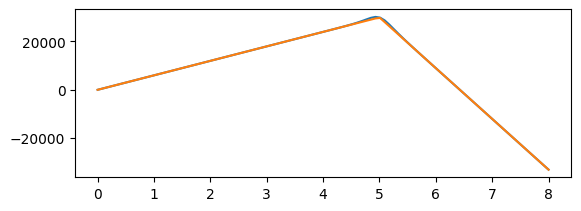

In [7]:
E = 3e10 #Pa
nu = 0.2 # Poisson's ratio
G = E / (2 * (1 + nu)) # Shear modulus
rho = 2400 # kg/m^3

mesh_size = 0.1

width = 5   # m
depth = 8   # m
t = 0.1     # m

x_prop = width / 2

H_exposed = 5.0
D_embed = 3.0
H_total = H_exposed + D_embed
L = H_total
EI = 20e6  # Nm²
gamma = 18.0 * 1e3  # N/m³
Ka = 0.333
Kp_mobilised = 1.5  # Reduced passive pressure coefficient
Kp = 3.0
z_prop = 2.5       # Depth of prop from top [m]
zR_prop = 60e3   # N/m (resisting direction, into wall)
zR_prop *= width

tol = 1e-7

def q_soil_smooth(z, width=0.2):

    # Lines on either side of the break
    m1      =  Ka * gamma                                   # slope for z ≤ H
    m2      = (Ka - Kp_mobilised) * gamma                   # slope for z ≥ H
    c2      =  Kp_mobilised * gamma * H_exposed             # intercept so the
                                                            # two branches meet
    # Smooth switch 0→1 built from tanh
    w = 0.5 * (1 + np.tanh((z - H_exposed) / width))        # 0 left, 1 right

    return (1 - w) * (m1 * z) + w * (m2 * z + c2)

def q_soil(z):
    return np.where(
        z <= H_exposed,
        Ka * gamma * z,
        Ka * gamma * z - Kp_mobilised * gamma * (z - H_exposed)
    )

z_plot = np.linspace(0, H_total, 100)
q_plot = q_soil_smooth(z_plot)
plt.subplot(211)
plt.plot(z_plot, q_plot)
plt.plot(z_plot, q_soil(z_plot))


In [8]:
wall = FEModel3D()

wall.add_material('Concrete', E, G, nu, rho)

#creating meshes
wall.add_rectangle_mesh('MESHES', mesh_size, width, depth, t, 'Concrete', plane = 'XZ', x_control = [width/2], y_control = [z_prop])
wall.meshes['MESHES'].generate()

for node in wall.nodes.values():
  if np.isclose(node.X, width/2, tol) and np.isclose(node.Z, z_prop, tol):
    print(node.X, node.Z)
    wall.add_node_load(node.name, 'FY', zR_prop, 'soil')
    break

for element in list(wall.quads.values()):
    Zavg = (element.i_node.Z + element.j_node.Z + element.m_node.Z + element.n_node.Z)/4
    wall.add_quad_surface_pressure(element.name, q_soil_smooth(Zavg), case='soil')

wall.add_load_combo('soil', {'soil': 1})
wall.merge_duplicate_nodes()

for node in wall.nodes.values():
    if (node.Z <= tol) or (depth - node.Z <= tol):
        wall.def_support(node.name, True, True, True, True, True, True)
    elif (node.X <= tol) or (width - node.X <= tol):
        wall.def_support(node.name, support_RZ = True)

wall.analyze(log=True, check_statics=True)

2.500000000000001 2.500000000000001
+-----------+
| Analyzing |
+-----------+

- Analyzing load combination soil
- Analyzing load step #1
- Adding nodal spring support stiffness terms to global stiffness matrix
- Adding spring stiffness terms to global stiffness matrix
- Adding member stiffness terms to global stiffness matrix
- Adding quadrilateral stiffness terms to global stiffness matrix
- Adding plate stiffness terms to global stiffness matrix
- Checking nodal stability
- Checking for tension/compression-only support spring convergence
- Checking for tension/compression-only spring convergence
- Checking for tension/compression-only member convergence
- Calculating reactions

- Analysis complete

+----------------+
| Statics Check: |
+----------------+

+------------------+--------+--------+-----------+----------+--------+--------+----------+-----------+--------+---------+-----------+----------+
| Load Combination | Sum FX | Sum RX |   Sum FY  |  Sum RY  | Sum FZ | Sum RZ |  Sum M

In [9]:
x = []
z= []
disp = []

rowx = []
rowy = []
rowz = []

prev = 0
i, j = 0, 0

for node in wall.nodes.values():
    X, Z, dy = node.X, node.Z, node.DY['soil']

    if np.isclose(X, width/2, tol) and np.isclose(Z, z_prop, tol):
      centre_coords = (i,j)

    if node.Z == prev:
      rowx.append(X)
      rowz.append(Z)
      rowy.append(dy)
      j += 1
    else:
      x.append(rowx)
      z.append(rowz)
      disp.append(rowy)

      rowx = [X]
      rowz = [Z]
      rowy = [dy]
      prev = node.Z

      i += 1
      j = 1
print(len(x))


80


(80, 51, 3)


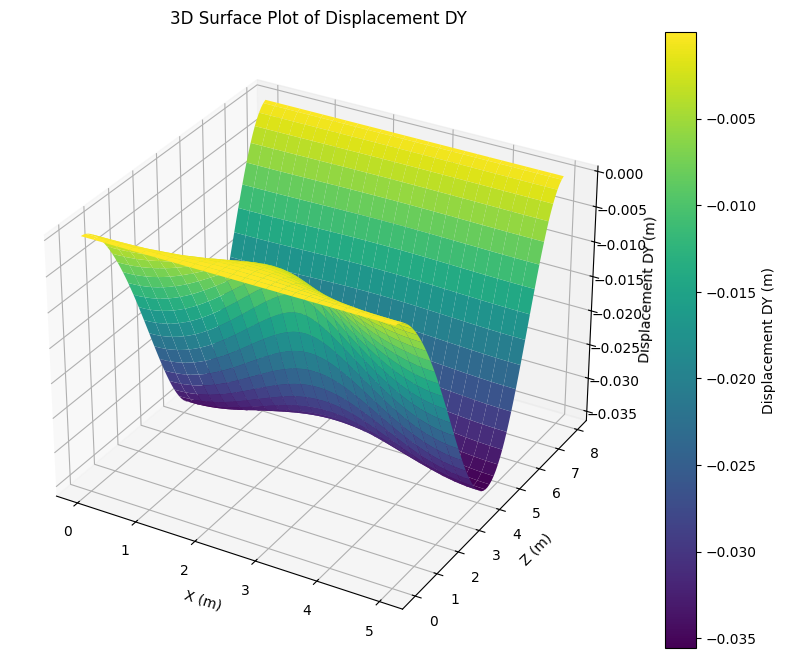

In [10]:
x = np.array(x)
z = np.array(z)
xdim, zdim = x.shape[1], x.shape[0]
disp = np.array(disp)
results = np.stack((x, z, disp), axis = -1)
print(results.shape)

# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x, z, disp, cmap='viridis')

# Add labels and title
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
ax.set_zlabel('Displacement DY (m)')
ax.set_title('3D Surface Plot of Displacement DY')

# Add a color bar
fig.colorbar(surf, label='Displacement DY (m)')

# Show the plot
plt.show()

In [11]:
from scipy.ndimage import laplace

D =  E * t**3 / (12 * (1 - nu**2))

def biharmonic(dy, dx, dz):

  d2u_dx2 = np.gradient(np.gradient(dy, dx, axis=1), dx, axis=1)
  d2u_dz2 = np.gradient(np.gradient(dy, dz, axis=0), dz, axis=0)
  lap     = d2u_dx2 + d2u_dz2

  d2lap_dx2 = np.gradient(np.gradient(lap, dx, axis=1), dx, axis=1)
  d2lap_dz2 = np.gradient(np.gradient(lap, dz, axis=0), dz, axis=0)
  bih       = d2lap_dx2 + d2lap_dz2

  return bih

def gaussian_2D(x, z, dx, dz, force, xc = width/2, zc = z_prop, sigma = 3e-2):

  r2 = ((x - xc)**2 + (z - zc)**2) / (2 * sigma**2)
  phi = np.exp(-r2)
  scale = force / (phi.sum() * dx * dz)

  return scale * phi


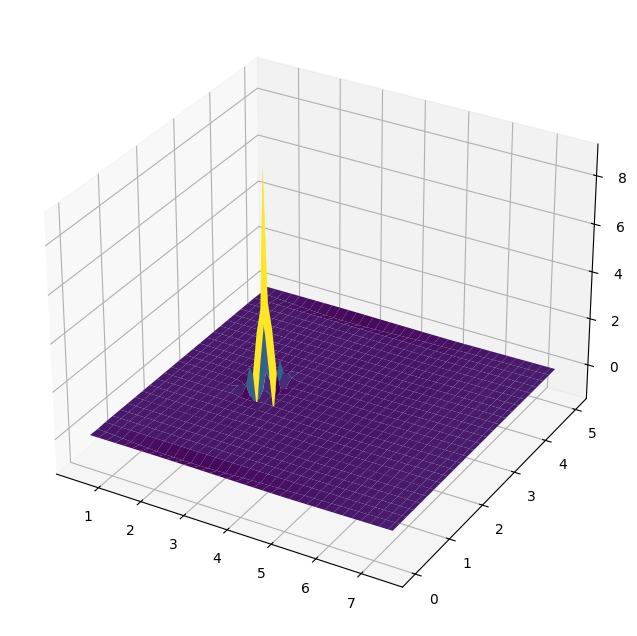

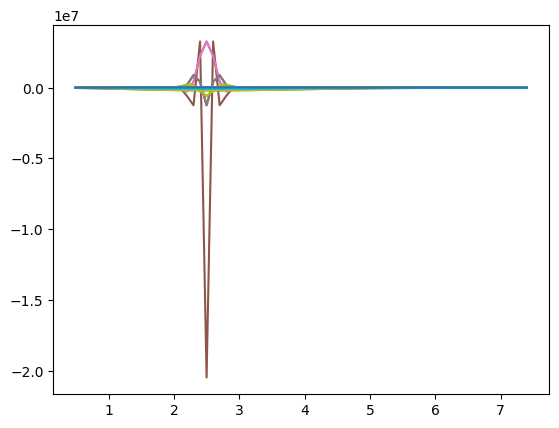

In [12]:
dx = x[0,1] - x[0,0]
dz = z[1,0] - z[0,0]

qs = q_soil_smooth(z)
q_prop = gaussian_2D(x, z, dx, dz, zR_prop)
q_total = qs - q_prop

del4 = biharmonic(disp, dx, dz) * D
residual = del4 + q_total


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Exclude the first and last 5 rows and columns for plotting
surf = ax.plot_surface(z[5:zdim - 5, :], x[5:zdim - 5, :], del4[5:zdim - 5, :], cmap='viridis')
plt.show()

for i in range(len(del4[0])):
  # Exclude the first and last 5 rows for plotting the 2D plots
  plt.plot(z[5:zdim - 5, i], residual[5:zdim - 5, i])

plt.show()

In [13]:
import tensorflow as tf
from tensorflow import keras

Normalise x, z , disp

In [14]:
print(results.shape)
np.save('2D_Wall_Propped.npy', results)

(80, 51, 3)
